# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
!pip install phik==0.11.1 -q

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import phik

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler)


In [3]:
geo_data_0=pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1=pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2=pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


*Данные загружены. Формат данных корректный. Проверяем на наличие дубликатов и пропусков.*

In [7]:
display(geo_data_0.isna().sum())
display(geo_data_0.duplicated().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

In [8]:
display(geo_data_1.isna().sum())
display(geo_data_1.duplicated().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

In [9]:
display(geo_data_2.isna().sum())
display(geo_data_2.duplicated().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

*Изучим данные на предмет сопоставимости, наличия аномалий и всплесков.*

In [10]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [11]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [12]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [13]:
geo_data_2['f0']

0       -1.146987
1        0.262778
2        0.194587
3        2.236060
4       -0.515993
           ...   
99995   -1.777037
99996   -1.261523
99997   -1.199934
99998   -2.419896
99999   -2.551421
Name: f0, Length: 100000, dtype: float64

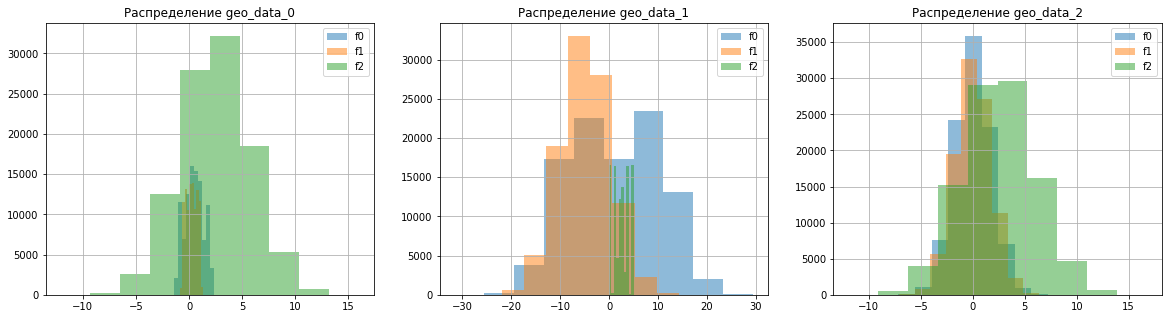

In [14]:
n=10
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
geo_data_0['f0'].hist(alpha=0.5,legend=True, ax=axes[0],bins=n)
geo_data_0['f1'].hist(alpha=0.5,legend=True, ax=axes[0],bins=n)
geo_data_0['f2'].hist(alpha=0.5,legend=True, ax=axes[0],bins=n)
axes[0].set_title('Распределение geo_data_0') 

geo_data_1['f0'].hist(alpha=0.5,legend=True, ax=axes[1],bins=n)
geo_data_1['f1'].hist(alpha=0.5,legend=True, ax=axes[1],bins=n)
geo_data_1['f2'].hist(alpha=0.5,legend=True, ax=axes[1],bins=n)
axes[1].set_title('Распределение geo_data_1') 

geo_data_2['f0'].hist(alpha=0.5,legend=True, ax=axes[2],bins=n)
geo_data_2['f1'].hist(alpha=0.5,legend=True, ax=axes[2],bins=n)
geo_data_2['f2'].hist(alpha=0.5,legend=True, ax=axes[2],bins=n)
axes[2].set_title('Распределение geo_data_2') 

plt.show()

Средний product geo_data_0  92.50000000000001
Средний product geo_data_1  68.82500000000002
Средний product geo_data_2  95.00000000000004


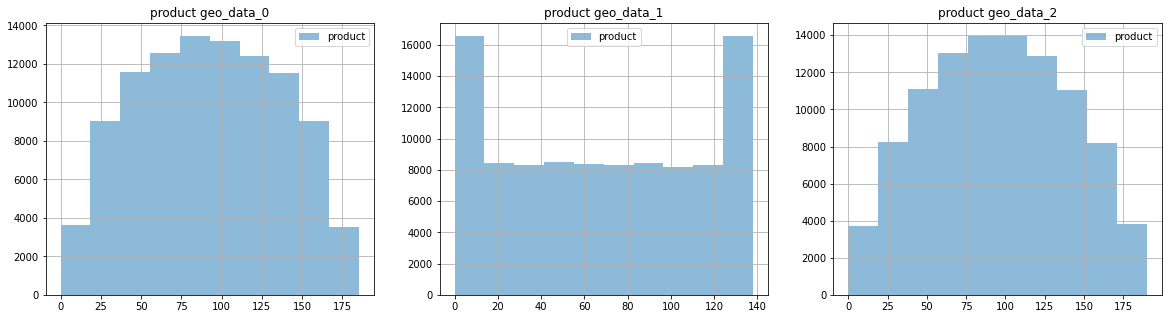

In [15]:
n=10
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
geo_data_0['product'].hist(alpha=0.5,legend=True, ax=axes[0],bins=n)
axes[0].set_title('product geo_data_0') 
print('Средний product geo_data_0 ',geo_data_0['product'].mean())

geo_data_1['product'].hist(alpha=0.5,legend=True, ax=axes[1],bins=n)
axes[1].set_title('product geo_data_1') 
print('Средний product geo_data_1 ',geo_data_1['product'].mean())

geo_data_2['product'].hist(alpha=0.5,legend=True, ax=axes[2],bins=n)
axes[2].set_title('product geo_data_2') 
print('Средний product geo_data_2 ',geo_data_2['product'].mean())

plt.show()

**Данные загружены и готовы к обучению модели. Видно, что регион 1 (geo_data_1) отличается по распределению признаков от других. Значения параметра f2 у него меньше, при том что f0 и f1 больше. У Региона 0 и Региона 2 распределение признака f2 схожи, но f0 и f1 у Региона 0 меньше, чем у других регионов. У Региона 2 наибольший средний объём запасов на скважину. При этом объем распределен между скважинами нормально. Регион 0 тоже распределен нормально по объемам выдачи между скваживами.**

## Обучение и проверка модели

*Построим модель на основании данных для каждого Региона.".*

*Проведем корреляционный анализ.*

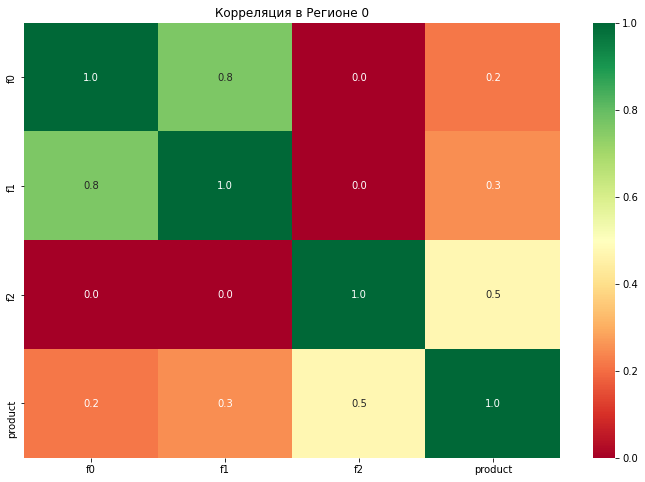

In [16]:
plt.figure(figsize=(12, 8))
sb.heatmap(geo_data_0.drop('id',axis=1) .phik_matrix(interval_cols =['f0','f1','f2','product']), cmap='RdYlGn', vmin=0,vmax=1,annot=True, fmt='.1f')
plt.title("Корреляция в Регионе 0")  
plt.show()

*На целевой показатель объем выдачи больше всего влияет f2. Между f0 и f1 есть сильная корреляция.*

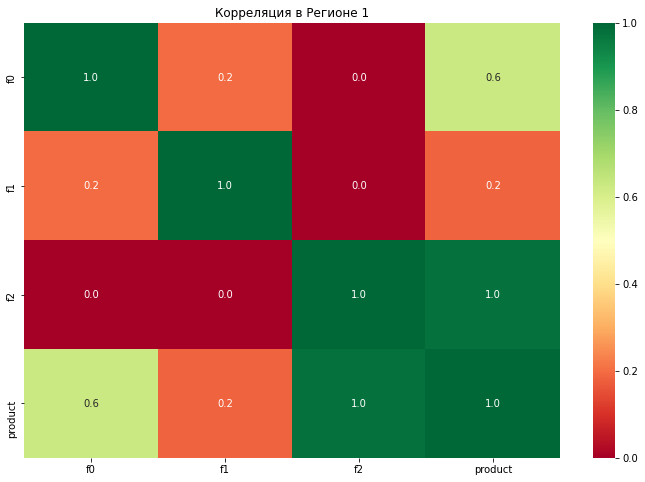

In [17]:
plt.figure(figsize=(12, 8))
sb.heatmap(geo_data_1.drop('id',axis=1) .phik_matrix(interval_cols =['f0','f1','f2','product']), cmap='RdYlGn', vmin=0,vmax=1,annot=True, fmt='.1f')
plt.title("Корреляция в Регионе 1")  
plt.show()

*На целевой показатель объем выдачи больше всего влияет f2, но f0 также имеется среднее влияение на product. Между факторами выраженной корреляции нет.*

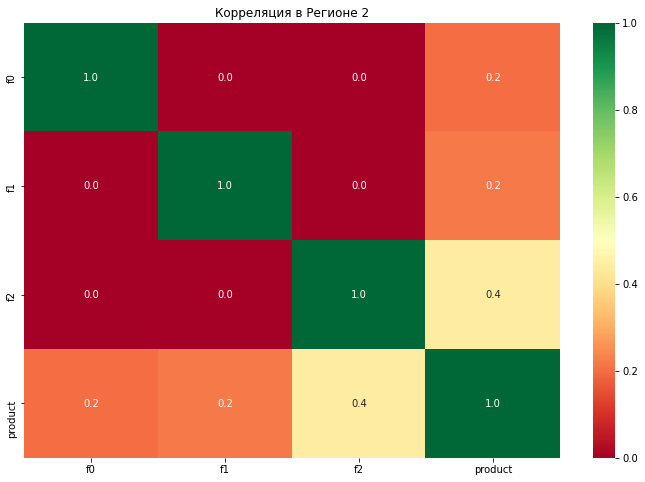

In [18]:
plt.figure(figsize=(12, 8))
sb.heatmap(geo_data_2.drop('id',axis=1) .phik_matrix(interval_cols =['f0','f1','f2','product']), cmap='RdYlGn', vmin=0,vmax=1,annot=True, fmt='.1f')
plt.title("Корреляция в Регионе 2")  
plt.show()

*На целевой показатель объем выдачи больше всего влияет f2, но корреляция не сильная. Между факторами значительной коррелции нет.*

Напишем функцию для обучения модели.

In [19]:
def mod (df):
        # создание константы RANDOM_STATE
        RANDOM_STATE = 42


        X = df.drop(['product','id'], axis=1)
        y = df['product']
        X_train, X_test, y_train, y_test =train_test_split(
          X, y, test_size=0.25, random_state=RANDOM_STATE
        )

        scaler = StandardScaler()

        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)


        # инициализация модели
        model_lr  = LinearRegression()
        model_lr.fit(X_train, y_train)
        predictions= model_lr.predict(X_test)
        rmse = mean_squared_error(y_test, predictions, squared=False)
        predictions_all=model_lr.predict(X)
        return predictions,rmse,predictions_all

In [20]:
result0=mod(geo_data_0)

In [21]:
display('Средний запас предсказанного сырья', result0[0].mean())
display('Корень среднеквадратичной ошибки', result0[1])

'Средний запас предсказанного сырья'

92.39879990657768

'Корень среднеквадратичной ошибки'

37.75660035026169

Добавим прогноз в geo_data_0.

In [22]:
result0=pd.DataFrame(result0[2],columns=['prediction'])

In [23]:
geo_data_0=pd.concat([geo_data_0,result0],axis=1)

In [24]:
geo_data_0.head()

,id,f0,f1,f2,product,prediction
0,txEyH,0.705745,-0.497823,1.221170,105.280062,124.654719
1,2acmU,1.334711,-0.340164,4.365080,73.037750,192.979834
2,409Wp,1.022732,0.151990,1.419926,85.265647,125.305517
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,155.264597
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,199.890193


Обучим модель и рассчитаем прогноз для geo_data_1.

In [25]:
result1=mod(geo_data_1)

In [26]:
display('Средний запас предсказанного сырья', result1[0].mean())
display('Корень среднеквадратичной ошибки', result1[1])

'Средний запас предсказанного сырья'

68.7128780391376

'Корень среднеквадратичной ошибки'

0.8902801001028846

Добавим прогноз в geo_data_1.

In [27]:
result1=pd.DataFrame(result1[2],columns=['prediction'])

In [28]:
geo_data_1=pd.concat([geo_data_1,result1],axis=1)

In [29]:
geo_data_1.head()

,id,f0,f1,f2,product,prediction
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,88.992417
1,62mP7,14.272088,-3.475083,0.999183,26.953261,96.580620
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,291.002259
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,316.666046
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,283.029201


Обучим модель и рассчитаем прогноз для geo_data_2.

In [30]:
result2=mod(geo_data_2)

In [31]:
display('Средний запас предсказанного сырья', result2[0].mean())
display('Корень среднеквадратичной ошибки', result2[1])

'Средний запас предсказанного сырья'

94.77102387765939

'Корень среднеквадратичной ошибки'

40.145872311342174

Добавим прогноз в geo_data_1.

In [32]:
result2=pd.DataFrame(result2[2],columns=['prediction'])

In [33]:
geo_data_2=pd.concat([geo_data_2,result2],axis=1)

In [34]:
geo_data_2.head()

,id,f0,f1,f2,product,prediction
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,78.521680
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,44.331005
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,-16.747569
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,113.228268
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,212.887827


**Итого были обучены три модели линейной регрессии для каждого Региона отдельно. Наименьший абсолютнй размер средней ошибки предсказаний модели в Регионе 1 - 0.89 баррелей. Наибольшая ошибка модели в Регионе 2 - 40 баррелей.**

## Подготовка к расчёту прибыли

Рассчитаем потенциальный доход от скважин с учетом того, что один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [35]:
profit=450000

In [36]:
geo_data_0['profit']=geo_data_0['product']*profit
geo_data_1['profit']=geo_data_1['product']*profit
geo_data_2['profit']=geo_data_2['product']*profit

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.  
Сравним полученный объём сырья со средним запасом в каждом регионе.  
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  

Расссчитаем средний расход на разведку скважины с учетом того, что выбирают 200 лучших для разработки. После чего рассчитаем необходимый объем добычи с учетом того, что доход с каждой единицы продукта составляет 450 тыс. рублей.

In [37]:
bud=10000000000

In [38]:
x=bud/200 #средний расход на разведку скважины 
y=x/profit #безубыточный объем добычи

In [39]:
print('средний расход на разведку скважины ',x)
print('безубыточный объем добычи ',y)

средний расход на разведку скважины  50000000.0
безубыточный объем добычи  111.11111111111111


Минимально допустимый объем добычи одной скважины 111.11 тысяч баррелей. Сравним полученный объём сырья со средним запасом в каждом регионе. 

In [40]:
display('Регион 0', geo_data_0['product'].mean())
display('Регион 1', geo_data_1['product'].mean())
display('Регион 2', geo_data_2['product'].mean())

'Регион 0'

92.50000000000001

'Регион 1'

68.82500000000002

'Регион 2'

95.00000000000004

**Судя по тому, что средние зачения по Регионам ниже безубыточного уровня добычи, есть риски убытков. Средние значения добычи Региона 2 больше всех.**

Рассчитаем возможные прибыли/убытки по каждой скважне.

In [41]:
geo_data_0['profit_loss']=geo_data_0['product']-y
geo_data_0.head()

,id,f0,f1,f2,product,prediction,profit,profit_loss
0,txEyH,0.705745,-0.497823,1.221170,105.280062,124.654719,4.737603e+07,-5.831049
1,2acmU,1.334711,-0.340164,4.365080,73.037750,192.979834,3.286699e+07,-38.073361
2,409Wp,1.022732,0.151990,1.419926,85.265647,125.305517,3.836954e+07,-25.845464
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,155.264597,7.587935e+07,57.509664
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,199.890193,6.931649e+07,42.925536


In [42]:
geo_data_1['profit_loss']=geo_data_1['product']-y
geo_data_1.head()

,id,f0,f1,f2,product,prediction,profit,profit_loss
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,88.992417,1.430596e+06,-107.932009
1,62mP7,14.272088,-3.475083,0.999183,26.953261,96.580620,1.212897e+07,-84.157850
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,291.002259,6.064484e+07,23.655194
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,316.666046,6.207543e+07,26.834297
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,283.029201,6.064484e+07,23.655194


In [43]:
geo_data_2['profit_loss']=geo_data_2['product']-y
geo_data_2.head()

,id,f0,f1,f2,product,prediction,profit,profit_loss
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,78.521680,1.249140e+07,-83.352438
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,44.331005,2.523136e+07,-55.041414
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,-16.747569,2.829236e+07,-48.239201
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,113.228268,5.155778e+07,3.461731
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,212.887827,6.732034e+07,38.489635


**Итого был рассчитан безубыточный объем добычи сырья и расходы на разработку одной скважины. Данные показатели помогут рассчитать прибыль или убыток.**

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [44]:
def count_profit (x):
    x=x.sort_values(by='prediction',ascending=False).head(200)
    profit1=x['product']*profit
    return profit1.sum()-bud

In [45]:
state = np.random.RandomState(12345)

values = []
for i in range(1000):
    # бутстреп выборка из исходных данных
    geo_data_0_subsample = geo_data_0.sample(500, replace=True, random_state=state)
    
    # вычисляем выручку для выборки
    value = count_profit(geo_data_0_subsample)
    values.append(value)

values = pd.DataFrame(values,columns=['profit'])

In [46]:
values['profit_mln']=values['profit']/1000000
values['profit_mln'].head()

0    152.937965
1     87.516486
2    -86.324654
3    328.417727
4    327.967965
Name: profit_mln, dtype: float64

In [47]:
values['profit_mln']
plt.show()

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [48]:
lower = values['profit_mln'].quantile(0.025)
upper = values['profit_mln'].quantile(0.975)
mean = values['profit_mln'].mean()
prob = (values['profit_mln'] < 0).sum() / len(values)*100

print("Средняя выручка Региона 0:",mean,'млн руб')
print("нижняя граница 95%-й доверительного интервала",lower)
print("верхняя граница 95%-й доверительного интервала",upper)
print(f'вероятность убытков {prob} %')

Средняя выручка Региона 0: 338.63025718801083 млн руб
нижняя граница 95%-й доверительного интервала -185.21034680980384
верхняя граница 95%-й доверительного интервала 908.2571272876413
вероятность убытков 9.6 %


**Рассчитаем параментры geo_data_1**

In [49]:
state = np.random.RandomState(12345)

values = []
for i in range(1000):
    # бутстреп выборка из исходных данных
    geo_data_1_subsample = geo_data_1.sample(500, replace=True, random_state=state)
    
    # вычисляем выручку для выборки
    value = count_profit(geo_data_1_subsample)
    values.append(value)

values = pd.DataFrame(values,columns=['profit'])

In [50]:
values['profit_mln']=values['profit']/1000000
values['profit_mln'].head()

0    514.819594
1    247.982310
2    502.690627
3    146.658782
4    331.454486
Name: profit_mln, dtype: float64

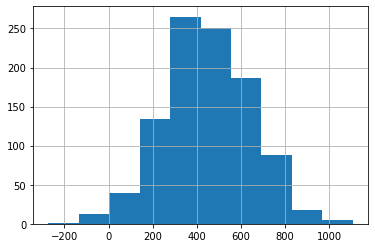

In [51]:
values['profit_mln'].hist()
plt.show()

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [52]:
lower = values['profit_mln'].quantile(0.025)
upper = values['profit_mln'].quantile(0.975)
mean = values['profit_mln'].mean()
prob = (values['profit_mln'] < 0).sum() / len(values)*100

print("Средняя выручка Региона 1:",mean,'млн руб')
print("нижняя граница 95%-й доверительного интервала",lower)
print("верхняя граница 95%-й доверительного интервала",upper)
print(f'вероятность убытков {prob} %')

Средняя выручка Региона 1: 448.76797410747866 млн руб
нижняя граница 95%-й доверительного интервала 38.89290579234434
верхняя граница 95%-й доверительного интервала 823.73973045032
вероятность убытков 1.4000000000000001 %


**Рассчитаем параментры geo_data_2**

In [53]:
state = np.random.RandomState(12345)

values = []
for i in range(1000):
    # бутстреп выборка из исходных данных
    geo_data_2_subsample = geo_data_2.sample(500, replace=True, random_state=state)
    
    # вычисляем выручку для выборки
    value = count_profit(geo_data_2_subsample)
    values.append(value)

values = pd.DataFrame(values,columns=['profit'])

In [54]:
values['profit_mln']=values['profit']/1000000
values['profit_mln'].head()

0    441.751565
1    483.369026
2    341.274581
3    362.559798
4     -7.531528
Name: profit_mln, dtype: float64

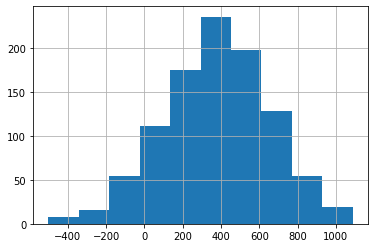

In [55]:
values['profit_mln'].hist()
plt.show()

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [56]:
lower = values['profit_mln'].quantile(0.025)
upper = values['profit_mln'].quantile(0.975)
mean = values['profit_mln'].mean()
prob = (values['profit_mln'] < 0).sum() / len(values)*100

print("Средняя выручка Региона 2:",mean,'млн руб')
print("нижняя граница 95%-й доверительного интервала",lower)
print("верхняя граница 95%-й доверительного интервала",upper)
print(f'вероятность убытков {prob} %')

Средняя выручка Региона 2: 374.4900859283456 млн руб
нижняя граница 95%-й доверительного интервала -177.9788936111065
верхняя граница 95%-й доверительного интервала 894.1964537454598
вероятность убытков 9.1 %


**Итого наименьшая вероятность убытков 1.4% в Регионе 2. Средняя вероятная прибыль в этом регионе тоже выше - 448.77 млн руб. Судя по распределению прибыли в этом Регионе самая стабильная выработка.**